# SAHOL HİSSE SENEDİ

In [1]:
# Veri okuma ve işleme adımında kullanılacak kütüphaneler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# !pip install tensorflow
import tensorflow as tf

# Model için kullanılacak kütüphaneler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Model değerlendirme ve veri ölçeklendirmede kullanılacak kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Uyarıları kapatmak için kullanılacak kütüphaneler
import itertools
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
df = pd.read_csv("SAHOL.IS.csv")

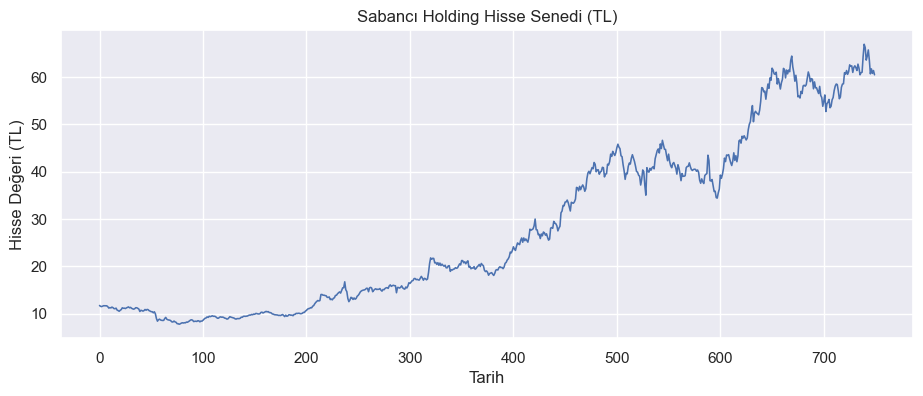

In [3]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = df["Close"].plot(linestyle='-', linewidth=1.15, label='Daily')
ax.set_ylabel("Hisse Değeri (TL)")
ax.set_xlabel("Tarih")
ax.set_title("Sabancı Holding Hisse Senedi (TL)")
plt.show();

In [4]:
# Eğitim-Doğrulama-Test seti olarak bölelim:   85-7.5-7.5
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)

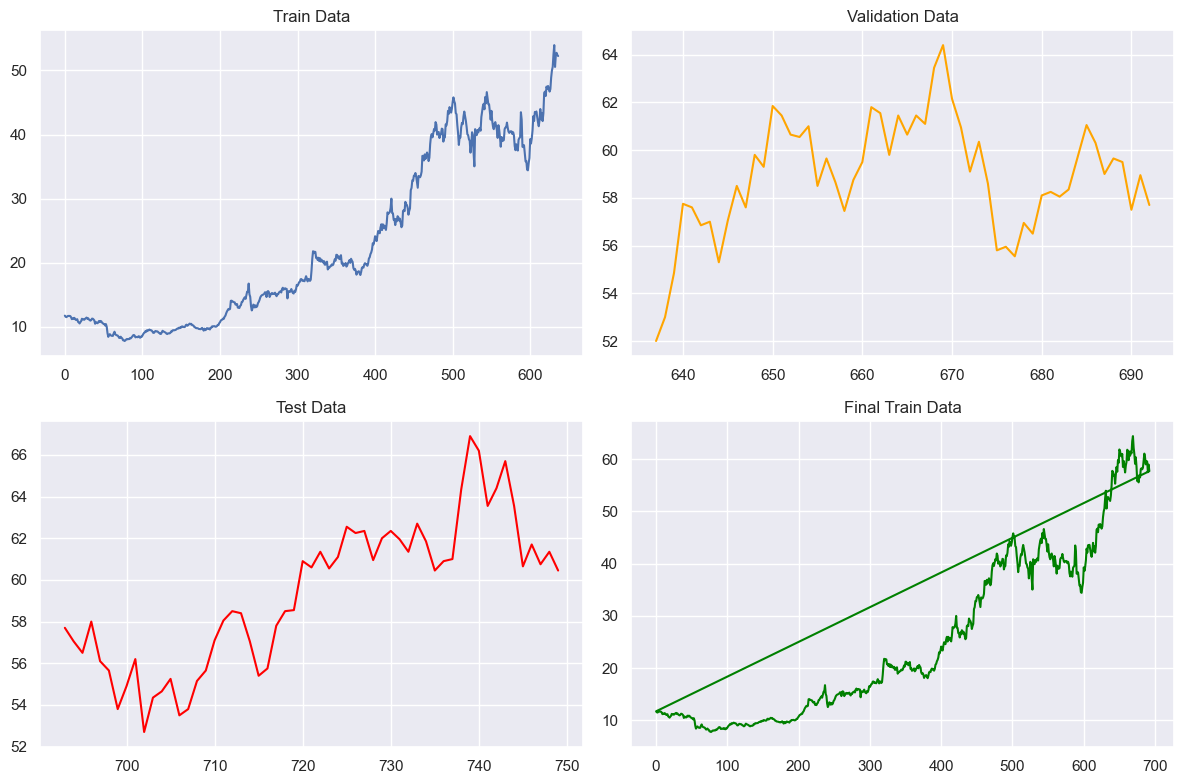

In [5]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
train.plot(ax=axes[0, 0], title="Train Data")
validation.plot(ax=axes[0, 1], title="Validation Data",color="orange")
test.plot(ax=axes[1, 0], title="Test Data",color="red")
final_train.plot(ax=axes[1, 1], title="Final Train Data",color="green")
plt.tight_layout()
plt.show();

# SES MODEL

## SES MODEL PARAMETRE OPTİMİZASYONU

In [6]:
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
len(train), len(validation), len(test)
def ses_optimizer(train, alphas, step=len(validation)):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        validation_pred = ses_model.forecast(step)
        mae = mean_absolute_error(validation, validation_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae
alphas = np.arange(0.01, 1, 0.01)
best_alpha, best_mae = ses_optimizer(train, alphas, step=len(validation)) # best_alpha: 0.57 best_mae: 6.589

best_alpha: 0.57 best_mae: 6.589


### ONE STEP AHEAD METHOD(SES)

In [7]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
sahol_ses_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = SimpleExpSmoothing(final_train).fit(smoothing_level=best_alpha)
    output = model_fit.forecast()
    yhat = output[0]
    sahol_ses_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### SES MODEL HATASI

In [8]:
sahol_ses_rmse = np.sqrt(mean_squared_error(test,sahol_ses_model_predictions))

test = np.array(test)
sahol_ses_model_predictions = np.array(sahol_ses_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
sahol_ses_mape = mape(test,sahol_ses_model_predictions) # MAPE =  2.081518242462227
print(sahol_ses_mape)

2.081518242462227


### SES MODELİNİN TAHMİN GRAFİĞİ:

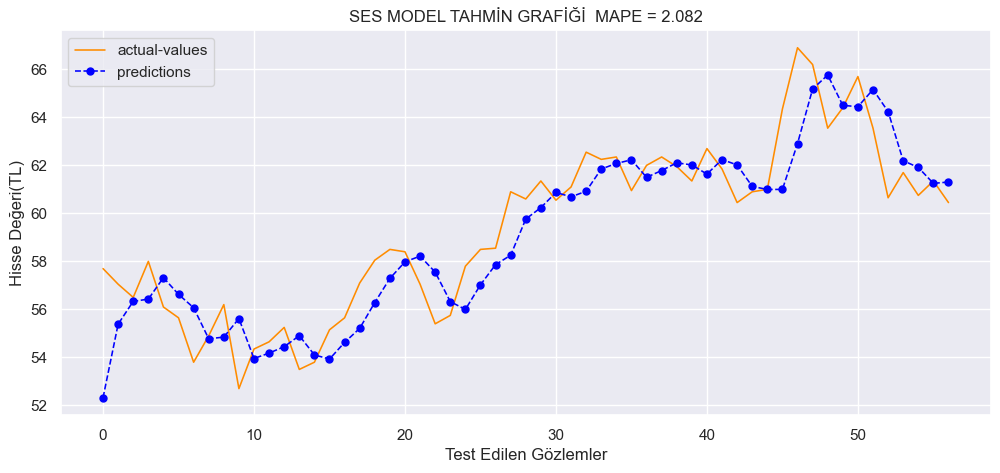

In [9]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(sahol_ses_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Test Edilen Gözlemler")
plt.ylabel("Hisse Değeri(TL)")
plt.title("SES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(sahol_ses_mape,3)))
plt.legend();

# DES MODEL

## DES MODEL PARAMETRE OPTİMİZASYONU

In [10]:
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
def des_optimizer(train, alphas, betas, step=len(validation)):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            validation_pred = des_model.forecast(step)
            mae = mean_absolute_error(validation, validation_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae
alphas = np.arange(0.01, 1, 0.01)
betas = np.arange(0.1, 1, 0.01)
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=len(validation))
# best_alpha: 0.08 best_beta: 0.98 best_mae: 2.1433

best_alpha: 0.08 best_beta: 0.98 best_mae: 2.1433


### ONE STEP AHEAD METHOD(DES)

In [11]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
sahol_des_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = ExponentialSmoothing(final_train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
    output = model_fit.forecast()
    yhat = output[0]
    sahol_des_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### DES MODEL HATASI

In [12]:
sahol_des_rmse = np.sqrt(mean_squared_error(test,sahol_des_model_predictions)) # RMSE = 10.320334750984863
test = np.array(test)
sahol_des_model_predictions = np.array(sahol_des_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
sahol_des_mape = mape(test,sahol_des_model_predictions)
print(sahol_des_mape) # MAPE = 3.0887397883684784

3.0887397883684784


### DES MODEL TAHMİN GRAFİĞİ:

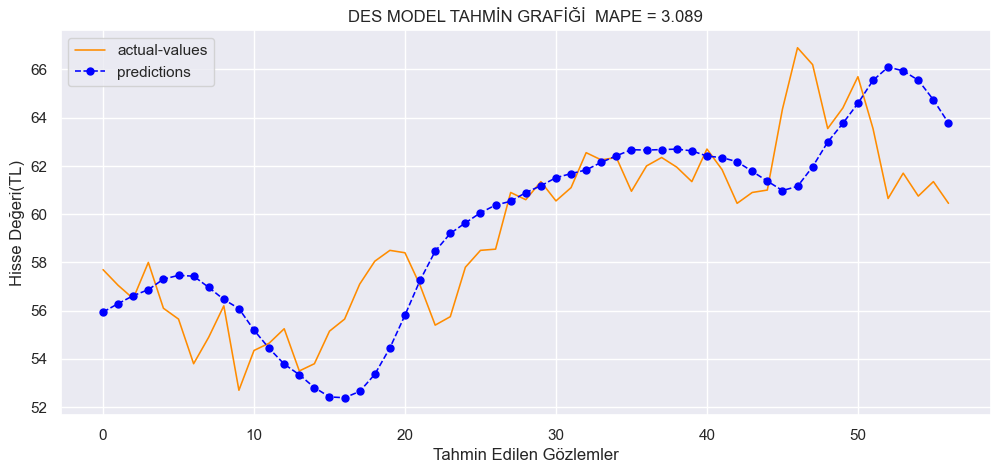

In [13]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(sahol_des_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tahmin Edilen Gözlemler")
plt.ylabel("Hisse Değeri(TL)")
plt.title("DES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(sahol_des_mape,3)))
plt.legend();

# TES MODEL

## TES MODEL PARAMETRE OPTİMİZASONU

In [14]:
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
def tes_optimizer(train, abg, step=len(validation)):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        validation_pred = tes_model.forecast(step)
        mae = mean_absolute_error(validation, validation_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae
alphas = betas = gammas = np.arange(0.01, 1, 0.1)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=len(validation))
# best_alpha: 0.11 best_beta: 0.71 best_gamma: 0.11 best_mae: 2.5116

best_alpha: 0.11 best_beta: 0.71 best_gamma: 0.11 best_mae: 2.5116


### ONE STEP AHEAD METHOD

In [15]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
sahol_tes_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = ExponentialSmoothing(final_train, trend="add", seasonal="add", seasonal_periods=5).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
    # model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    sahol_tes_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### TES MODEL HATASI

In [16]:
sahol_tes_rmse = np.sqrt(mean_squared_error(test,sahol_tes_model_predictions)) # RMSE = 4.622969967001846
test = np.array(test)
sahol_tes_model_predictions = np.array(sahol_tes_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
sahol_tes_mape = mape(test,sahol_tes_model_predictions)
print(sahol_tes_mape) # MAPE = 3.2905066033646873

3.2905066033646873


### TES MODEL TAHMİN GRAFİĞİ:

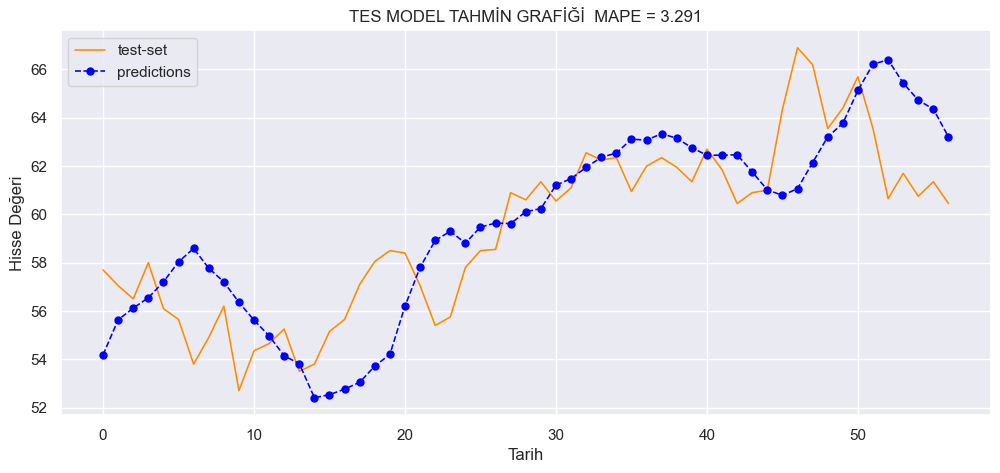

In [17]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(sahol_tes_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("TES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(sahol_tes_mape,3)))
plt.legend();

# ARIMA

## ARIMA MODEL PARAMETRE OPTİMİZASYONU

In [18]:
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model = sm.tsa.ARIMA(train, order=order).fit()
            aic = arima_model.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params
best_params_aic = arima_optimizer_aic(train, pdq)
# Best ARIMA(3, 1, 3) AIC=1458.25  <- parametreler.

Best ARIMA(3, 1, 3) AIC=1458.25


### ONE STEP AHEAD METHOD(ARIMA)

In [19]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
sahol_arima_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model = sm.tsa.ARIMA(final_train, order=best_params_aic)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    sahol_arima_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### ARIMA MODEL HATASI

In [20]:
sahol_arima_rmse = np.sqrt(mean_squared_error(test,sahol_arima_model_predictions)) # RMSE = 3.1332348079593957
test = np.array(test)
sahol_arima_model_predictions = np.array(sahol_arima_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
sahol_arima_mape = mape(test,sahol_arima_model_predictions) 
print(sahol_arima_mape) # MAPE = 2.0153834239496566

2.0153834239496566


### ARIMA MODEL TAHMİN GRAFİĞİ:

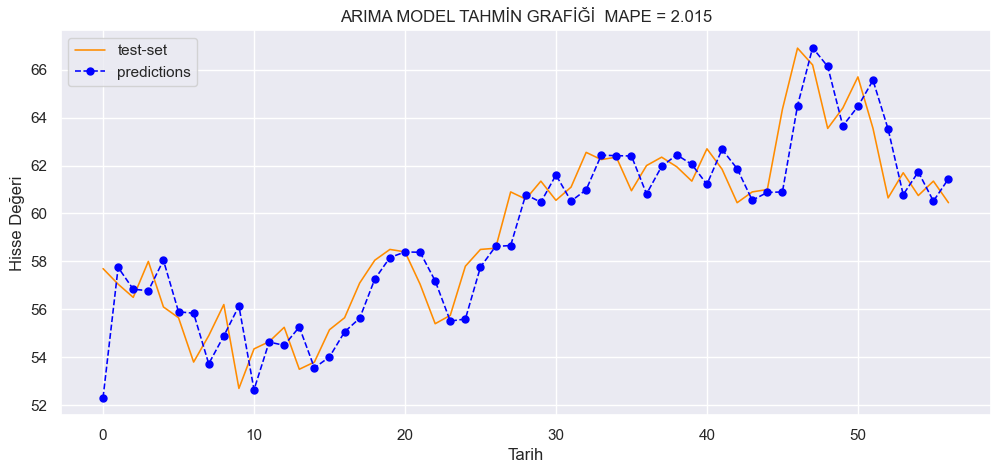

In [21]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(sahol_arima_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("ARIMA MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(sahol_arima_mape,3)))
plt.legend();

# SARIMA MODEL

## SARIMA MODEL PARAMETRE OPTİMİZASYONU

In [22]:
index = df.shape[0]*0.85
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 5) for x in list(itertools.product(p, d, q))]
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)
# SARIMA(0, 1, 0)x(1, 0, 1, 5)12 - AIC:1462.9989211697125 <- parametreler.

SARIMA(0, 1, 0)x(1, 0, 1, 5)12 - AIC:1462.9989211697125


In [23]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
sahol_sarima_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model = SARIMAX(final_train, order=best_order, seasonal_order=best_seasonal_order)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    sahol_sarima_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### SARIMA MODEL HATASI

In [24]:
sahol_sarima_rmse = np.sqrt(mean_squared_error(test,sahol_sarima_model_predictions)) # RMSE = 3.13743723917444
test = np.array(test)
sahol_sarima_model_predictions = np.array(sahol_sarima_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
sahol_sarima_mape = mape(test,sahol_sarima_model_predictions) # MAPE = 2.025064867984994
print(sahol_sarima_mape)

2.025064867984994


### SARIMA MODEL TAHMİN GRAFİĞİ:

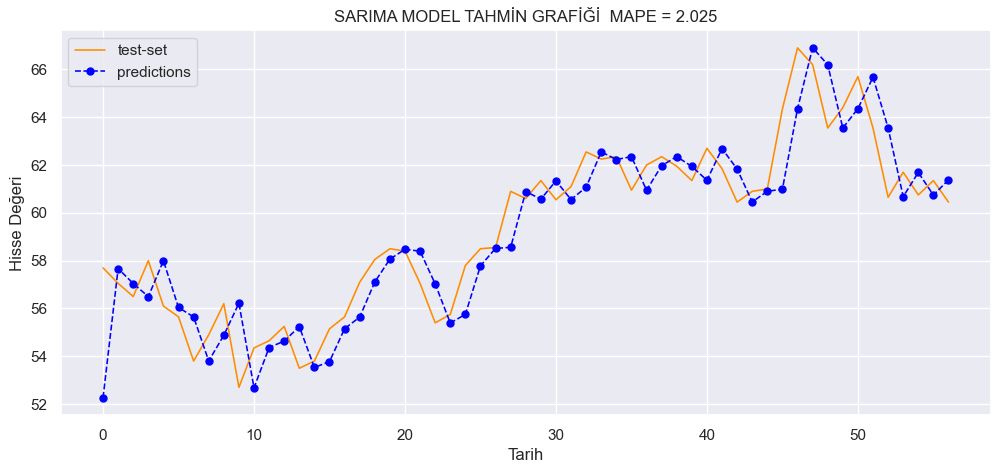

In [25]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(sahol_sarima_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("SARIMA MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(sahol_sarima_mape,3)))
plt.legend();

# ANN MODEL(LSTM)

In [26]:
data = pd.read_csv("SAHOL.IS.csv")
prices = data['Close'].values

### Veri Ölçeklendirme

In [27]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

### ONE STEP AHEAD METHOD DATA CREATION

In [28]:
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)
lookback = 30

In [29]:
train_size = int(len(prices_scaled) * 0.925) 
train_data = prices_scaled[:train_size]
test_data = prices_scaled[train_size - lookback:]  
train_size, len(train_data), len(test_data)

(693, 693, 87)

In [30]:
# Ayrı ayrı veri seti oluştur
X_train, y_train = create_dataset(train_data, lookback)
X_test, y_test = create_dataset(test_data, lookback)
# LSTM için giriş verisini yeniden şekillendir
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [31]:
# Model oluştur
tf.random.set_seed(42)
model = Sequential([
    LSTM(50, activation='relu', input_shape=(lookback, 1)),
    Dense(1)])
# Modeli derle
model.compile(optimizer='adam', loss='mse')
# Modeli eğit
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1231 - val_loss: 0.0104
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - val_loss: 0.0093
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.4624e-04 - val_loss: 0.0021
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5904e-04 - val_loss: 0.0018
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0964e-04 - val_loss: 0.0016
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7530e-04 - val_loss: 0.0015
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4409e-04 - val_loss: 0.0014
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9735e-04 - val_loss: 0.0013
Epoch 10/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8039e-04 - val_loss: 0.0013
Epoch 11/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6448e-04 - val_loss: 0.0012
Epoch 12/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 

### ANN MODEL HATASI

In [32]:
sahol_ann_pred = model.predict(X_test)
# Veriyi orijinal ölçeğe geri çevir
y_pred_ann_inverse = scaler.inverse_transform(sahol_ann_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
def mape(actual, predictions):
    return np.mean(np.abs((actual - predictions) / actual)) * 100
sahol_ann_mape = mape(y_test_inverse, y_pred_ann_inverse)
print(sahol_ann_mape) # MAPE = 2.575679747842831

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2.698212929609354


In [33]:
test = np.array(y_test_inverse)
sahol_ann_model_predictions = np.array(y_pred_ann_inverse)

### ANN MODEL TAHMİN GRAFİĞİ:

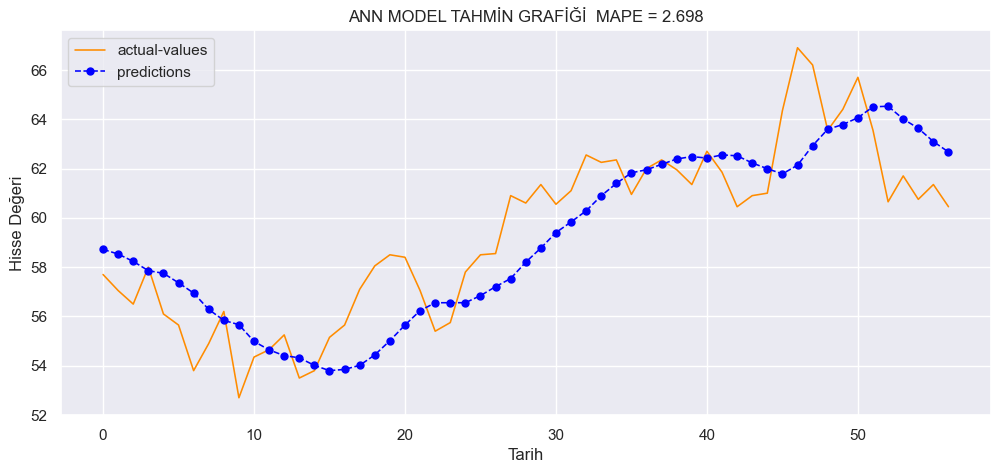

In [34]:
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(sahol_ann_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("ANN MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(sahol_ann_mape,3)))
plt.legend();

# CNN MODEL

In [35]:
from tensorflow.keras.layers import Conv1D, Dense, Flatten

In [36]:
data = pd.read_csv("SAHOL.IS.csv")
prices = data["Close"].values

In [37]:
# Parametreler
lookback = 10
test_size = 57
# Veriyi böl (lookback'i unutma!)
train_prices = prices[:-(test_size)]
test_prices = prices[-(test_size + lookback):]  # Test için lookback öncesi veriler dahil edilir
# Ölçeklendirme (sadece train'e fit et)
scaler = MinMaxScaler(feature_range=(0, 1))
train_prices_scaled = scaler.fit_transform(train_prices.reshape(-1, 1))
test_prices_scaled = scaler.transform(test_prices.reshape(-1, 1))

In [38]:
# Dataset oluşturma fonksiyonu
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)
X_train, y_train = create_dataset(train_prices_scaled, lookback)
X_test, y_test = create_dataset(test_prices_scaled, lookback)

In [39]:
# CNN için reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [40]:
# Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(lookback, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
# Compile
model.compile(optimizer='adam', loss='mse')
# Eğitim
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test));

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0527 - val_loss: 0.0028
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 9.1816e-04 - val_loss: 0.0017
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 8.4263e-04 - val_loss: 0.0017
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2551e-04 - val_loss: 0.0017
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 8.0808e-04 - val_loss: 0.0016
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 7.9201e-04 - val_loss: 0.0015
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 7.8158e-04 - val_loss: 0.0013
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 7.7650e-04 - val_loss: 0.0012
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 7.7389e-04 - val_loss: 0.0012
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 7.6807e-04 - val_loss: 0.0012
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 7.5531e-04 - val_loss: 0.0013
Epoch 12/20
43/4

### CNN MODEL HATASI

In [41]:
y_pred_scaled = model.predict(X_test)
sahol_cnn_y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
def mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100
sahol_cnn_mape = mape(y_test_inverse, sahol_cnn_y_pred)
print(f"Test MAPE: {sahol_cnn_mape}") # Test MAPE: 2.2933839484052467

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test MAPE: 2.4253234477722785


### CNN MODEL TAHMİN GRAFİĞİ:

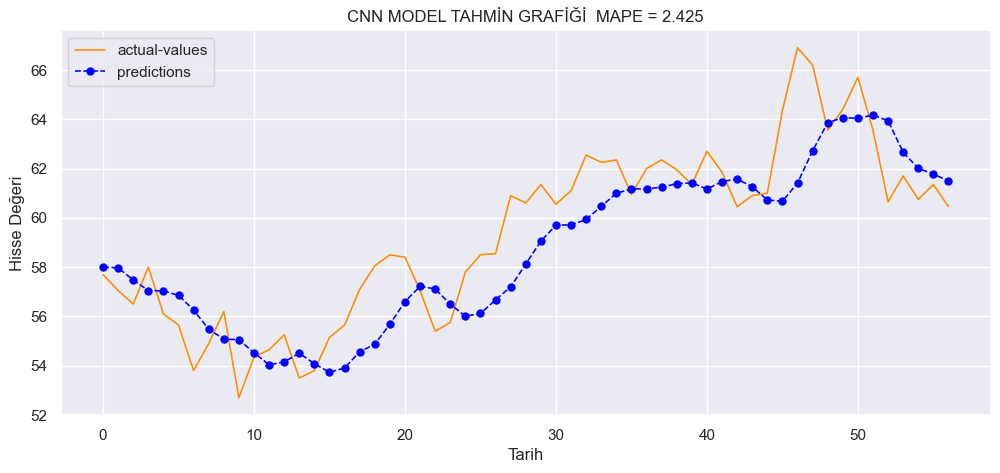

In [42]:
import matplotlib.pyplot as plt
plt.plot(y_test_inverse,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(sahol_cnn_y_pred,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("CNN MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(sahol_cnn_mape,3)))
plt.legend();

### KOMBİNASYON YÖNTEMİ VE BAŞARISI

## YÖNTEMLERİN MAPE DEĞERLERİ:

In [43]:
best_model = pd.DataFrame([sahol_ses_mape, sahol_des_mape, sahol_tes_mape,
                           sahol_arima_mape, sahol_sarima_mape,
                           sahol_ann_mape, sahol_cnn_mape],

                          index=["SES MODEL", "DES MODEL", "TES MODEL", "ARIMA MODEL", "SARIMA MODEL","ANN MODEL","CNN MODEL"],

                          columns=["MAPE Değerleri"])
print(best_model.sort_values("MAPE Değerleri", ascending=True));

              MAPE Değerleri
ARIMA MODEL         2.015383
SARIMA MODEL        2.025065
SES MODEL           2.081518
CNN MODEL           2.425323
ANN MODEL           2.698213
DES MODEL           3.088740
TES MODEL           3.290507


**EN DÜŞÜK MAPE DEĞERİNE SAHİP 3 YÖNTEMİN ORTALAMASINI ALALIM**

In [44]:
predictions = np.stack([sahol_arima_model_predictions.flatten(), sahol_sarima_model_predictions.flatten(),sahol_ses_model_predictions.flatten()], axis=1)

# Bu tahminlerin ortalaması:
average_predictions = np.mean(predictions, axis=1)

print(average_predictions)

[52.29880523 56.93544411 56.73913787 56.56761977 57.78958046 56.18932994
 55.85093601 54.1027685  54.87183386 55.99209513 53.09441462 54.39336144
 54.528261   55.13568615 53.73178906 53.9076333  54.9467451  55.49270033
 56.88568142 57.83963925 58.2833906  58.33305915 57.25646217 55.74323389
 55.78239732 57.52516475 58.33510609 58.49218681 60.4812142  60.42792983
 61.27177942 60.58724031 60.99597552 62.27771331 62.24108861 62.32835367
 61.08855604 61.90770315 62.30325747 62.00151327 61.40551585 62.53493501
 61.90720696 60.71147772 60.92550533 60.96355117 63.91963912 66.33565021
 66.03184594 63.90206097 64.42288735 65.46457781 63.77261823 61.22013596
 61.77989188 60.83664351 61.37905291]


**KOMBİNE EDİLEN TAHMİNLERİN MAPE DEĞERİ**

In [45]:
from sklearn.metrics import mean_absolute_percentage_error
combined_mape = mean_absolute_percentage_error(test,average_predictions)*100
print(combined_mape) #  MAPE = 1.9370097134269415

1.9370097134269415


In [49]:
best_model = pd.DataFrame([sahol_arima_mape, sahol_sarima_mape,
                        sahol_ses_mape,combined_mape],

                          index=["ARIMA MODEL", "SARIMA MODEL","SES MODEL","COMBINED PREDICTION"],

                          columns=["SAHOL MAPE Değerleri"])
print(best_model.sort_values("SAHOL MAPE Değerleri", ascending=True));

                     SAHOL MAPE Değerleri
COMBINED PREDICTION              1.937010
ARIMA MODEL                      2.015383
SARIMA MODEL                     2.025065
SES MODEL                        2.081518


In [48]:
combined_RMSE = np.sqrt(mean_squared_error(test,average_predictions)) # RMSE = 1.5401875579197315
print(combined_RMSE);

1.5401875579197315


In [50]:
best_model_RMSE = pd.DataFrame([sahol_sarima_rmse, sahol_arima_rmse,
                           sahol_ses_rmse, combined_RMSE],

                          index=["SARIMA MODEL", "ARIMA MODEL","CNN MODEL","COMBINED PREDICTION"],

                          columns=["SAHOL RMSE Değerleri"])
print(best_model_RMSE.sort_values("SAHOL RMSE Değerleri", ascending=True));

                     SAHOL RMSE Değerleri
COMBINED PREDICTION              1.540188
ARIMA MODEL                      1.553347
SARIMA MODEL                     1.553495
CNN MODEL                        1.619064


**Kombine tahminler en başarılı tahminler olmuştur!**

## KOMBİNE TAHMİNLERİN GRAFİĞİ:

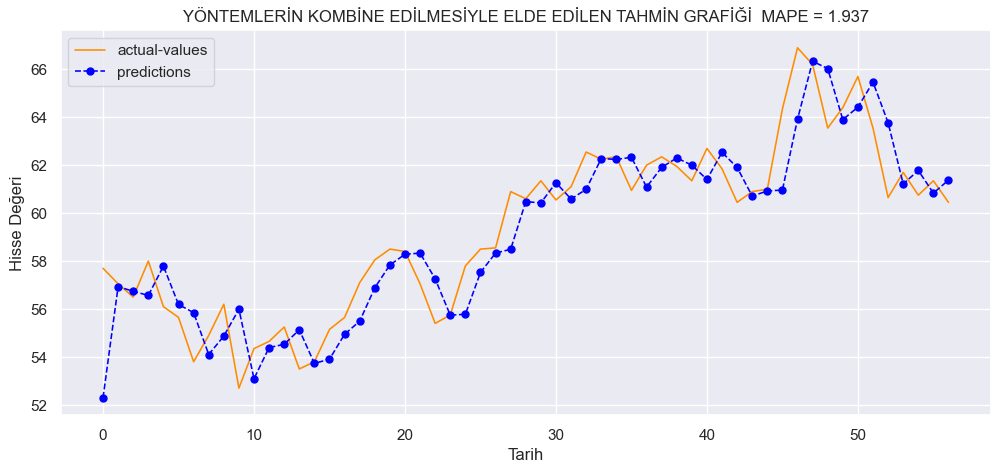

In [47]:
import matplotlib.pyplot as plt
plt.plot(y_test_inverse,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(average_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("YÖNTEMLERİN KOMBİNE EDİLMESİYLE ELDE EDİLEN TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(combined_mape,3)))
plt.legend();

**En düşük MAPE değerine sahip yöntemlerin kombine edilmesiyle elde edilen tahminler yüzdelik olarak en düşük hatayı veren tahminler olmuştur!**